In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
income = pd.read_csv('adult_income.csv')

In [3]:
income.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [4]:
income.columns = income.columns.str.replace('.','_')

In [5]:
income['income_map'] = income.income.map({'<=50K':0, '>50K': 1})
income['sex_map'] = income.sex.map({'Female':0, 'Male':1})
income['race_map']=income.race.map({'White':0, 'Black':1, 
                                    'Asian-Pac-Islander':2, 'Amer-Indian-Eskimo':3})
income['marital_map'] = income.marital_status.map({'Widowed':0, 'Divorced':1, 'Separated':2,
                                                  'Never-married':3, 'Married-civ-spouse':4,
                                                  'Married-spouse-absent':5, 'Married-AF-spouse':6})
income['rel_map']=income.relationship.map({'Not-in-family':0, 'Unmarried':0, 
                                           'Own-child':0, 'Other-relative':0, 
                                           'Husband':1, 'Wife':1})
income['work_map']=income.workclass.map({'?':0, 'Private':1, 'State-gov':2, 'Federal-gov':3, 
                                        'Self-emp-not-inc':4, 'Self-emp-inc': 5, 'Local-gov': 6,
                                        'Without-pay':7, 'Never-worked':8})

In [6]:
num_cols = ['age', 'sex_map', 'race_map','education_num', 'work_map', 
            'marital_map', 'rel_map', 'hours_per_week','capital_gain', 'capital_loss', 
            'fnlwgt', 'income_map']

In [7]:
income=income[num_cols].fillna(-9999)

In [8]:
income.head()

,age,sex_map,race_map,education_num,work_map,marital_map,rel_map,hours_per_week,capital_gain,capital_loss,fnlwgt,income_map
0,90,0,0.0,9,0,0,0,40,0,4356,77053,0
1,82,0,0.0,9,1,0,0,18,0,4356,132870,0
2,66,0,1.0,10,0,0,0,40,0,4356,186061,0
3,54,0,0.0,4,1,1,0,40,0,3900,140359,0
4,41,0,0.0,10,1,2,0,40,0,3900,264663,0


In [9]:
features=['age', 'sex_map', 'race_map','education_num', 'work_map', 
          'marital_map', 'rel_map', 'hours_per_week','capital_gain', 
          'capital_loss', 'fnlwgt']

target=['income_map']

In [10]:
X = income[features].values
y = income[target].values.flatten()

In [11]:
from sklearn.model_selection import train_test_split
    
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)

# Logistic Regression

In [12]:
def logistic_regression():
    
    # Instantiates and trains a logistic regression model using grid search  
    # to find optimalhyperparameter values 
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import GridSearchCV
    from sklearn.exceptions import FitFailedWarning
    import warnings
    warnings.simplefilter('always', FitFailedWarning)

    logreg = LogisticRegression()
    grid_values = {'penalty' : ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100]}
    
    grid_lr_rec = GridSearchCV(logreg, param_grid = grid_values, scoring = 'accuracy')
    with warnings.catch_warnings(record=True) as w:
       try:
         grid_lr_rec.fit(X, y)  # This will raise a ValueError since C is < 0
       except ValueError:
         pass
       return grid_lr_rec.best_estimator_    

In [13]:
logreg = logistic_regression()

#Analysis of Income using the Machine Learning Algorithm

Evaluation

In [14]:
def evaluation(model):
    from sklearn.metrics import classification_report
    
    # This function gives provides verious evaluation metrics for the input model
    
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test, y_pred, target_names = ['Under 50k', 'Over 50k']))
    print('Training Set Accuracy Score: {:.2f}'.format(model.score(X_train, y_train)))
    print('Testing Set Accuracy Score: {:.2f}'.format(model.score(X_test, y_test)))

In [15]:
evaluation(logreg)

              precision    recall  f1-score   support

   Under 50k       0.81      0.97      0.88      6193
    Over 50k       0.72      0.27      0.39      1948

    accuracy                           0.80      8141
   macro avg       0.76      0.62      0.63      8141
weighted avg       0.79      0.80      0.76      8141

Training Set Accuracy Score: 0.80
Testing Set Accuracy Score: 0.80


Confusion

In [16]:
def confusion(model):
    
    # Creats a confusion matrix/heatmap for the logistic regression models predicted values
    from sklearn.metrics import confusion_matrix
    
    y_pred = model.predict(X_test)
    confusion_mc = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(confusion_mc)

    plt.figure(figsize=(5.5,4))
    sns.heatmap(df_cm, annot=True)
    n1=model.score(X_test, y_test)
    plt.title('Model Accuracy:{:.2%}'.format(round(n1,2)))

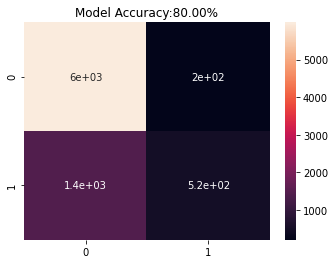

In [17]:
confusion(logreg)

Precision recall

The Precision-Recall curve shows the trade off between precision and recall scores as we vary the decision threshold for classification (using either using either a probability threshold or a decision function threshold).

In [18]:
def precision_recall(model):
    from sklearn.metrics import precision_recall_curve
    
    proba = model.predict_proba(X_test)
    
    precision, recall, threshold = precision_recall_curve(y_test, proba[:,1])
    
    plt.plot(precision, recall)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision-Recall Curve')

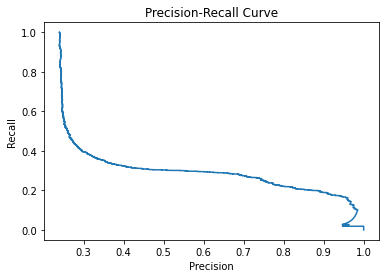

In [19]:
precision_recall(logreg)

Roc Curve

The ROC curve (Receiver Operating Charastic) preforms the same feat for the True Positive Rate (recall) and the False Positive Rate. 

In [20]:
def roc_curve(model):
    from sklearn.metrics import roc_curve, auc
    
    #scores = model.decision_function(X_test)
    proba = model.predict_proba(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, proba[:,1])
    
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve. AUC: {}'.format(auc(fpr, tpr)))

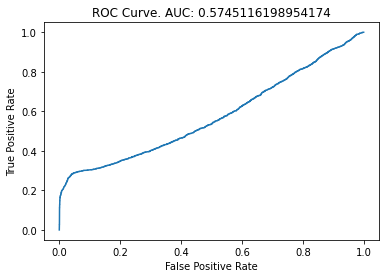

In [21]:
roc_curve(logreg)

Micro Average and Macro Average

When the micro average (each instance has same weight) preforms better than the macro average (each class has same weight) this is an indicator that the model is preforming better on the more frequent class. This holds true with the results from the evaluation function above, in which the model performed substantially better on the class earning less than $50,000.

In [22]:
from sklearn.metrics import precision_score

y_pred = logreg.predict(X_test)

micro_avg = precision_score(y_test, y_pred, average='micro')
macro_avg = precision_score(y_test, y_pred, average='macro')

print('Micro Average Precision Score: {:.2f}'.format(
    precision_score(y_test, y_pred, average='micro')))
print('Macro Average Precision Score: {:.2f}'.format(
    precision_score(y_test, y_pred, average='macro')))


Micro Average Precision Score: 0.80
Macro Average Precision Score: 0.76


# Income Class of Adults (Above and Below 50k)

In [23]:
print('Number of instances in the > $50,000 class: {}'.format(
    len(income[income.income_map ==1])))
print('Number of instances in the < $50,000 class: {}'.format(
    len(income[income.income_map ==0])))

Number of instances in the > $50,000 class: 7841
Number of instances in the < $50,000 class: 24720
